# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

## Data pre-processing

In [13]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

 ### Histogram of the output labels 

We should check for class imbalance.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129110b50>,
      dtype=object)

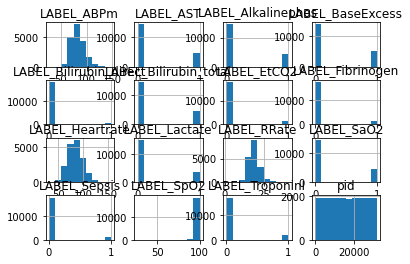

In [3]:
df_train_labels.hist()

# with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Train Data pre-processing

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

In [ ]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

In [ ]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [25]:
df_train_agg_features = df_train_features.groupby('pid').agg([np.min, np.max, np.mean])
df_train_agg_features = df_train_agg_features.iloc[:,5:]
# Removing ETCo2
df_train_agg_features = df_train_agg_features.drop(df_train_agg_features.columns[[1,2,3]],  axis = 1)
print(df_train_agg_features.columns)
df_train_agg_features.columns
print(int(df_train_agg_features.shape[1]))
print(int(df_train_agg_features.shape[1]/3))

# how much missing data? 
print("number of missing values:")
print(df_train_agg_features.isnull().sum(axis=0))

na_percent_max = int(0.8 * df_train_agg_features.shape[0])
tmp = pd.DataFrame(df_train_agg_features)
for i in range(1, (int(df_train_agg_features.shape[1]/3))):
    na_count = df_train_agg_features.iloc[:,i].isna().sum()
    print(df_train_agg_features.columns[i])
    print(na_count)
    
    if(na_count > na_percent_max):
        print("should be removed")


MultiIndex([(             'Age', 'mean'),
            (             'PTT', 'amin'),
            (             'PTT', 'amax'),
            (             'PTT', 'mean'),
            (             'BUN', 'amin'),
            (             'BUN', 'amax'),
            (             'BUN', 'mean'),
            (         'Lactate', 'amin'),
            (         'Lactate', 'amax'),
            (         'Lactate', 'mean'),
            (            'Temp', 'amin'),
            (            'Temp', 'amax'),
            (            'Temp', 'mean'),
            (             'Hgb', 'amin'),
            (             'Hgb', 'amax'),
            (             'Hgb', 'mean'),
            (            'HCO3', 'amin'),
            (            'HCO3', 'amax'),
            (            'HCO3', 'mean'),
            (      'BaseExcess', 'amin'),
            (      'BaseExcess', 'amax'),
            (      'BaseExcess', 'mean'),
            (           'RRate', 'amin'),
            (           'RRate', '

In [26]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors = 10)
#imputer = IterativeImputer(random_state=0, verbose = 2, max_iter = 30)
df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)
#print(df_train_agg_imputed_features)

In [27]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [ ]:
# REARRANGE THE LABELS, TO MATCH THE REARRANGED FEATURES
# df_train_labels_sorted = df_train_labels.sort_values(by = 'pid')
# print(df_train_labels_sorted)

In [ ]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

### PCA plot 

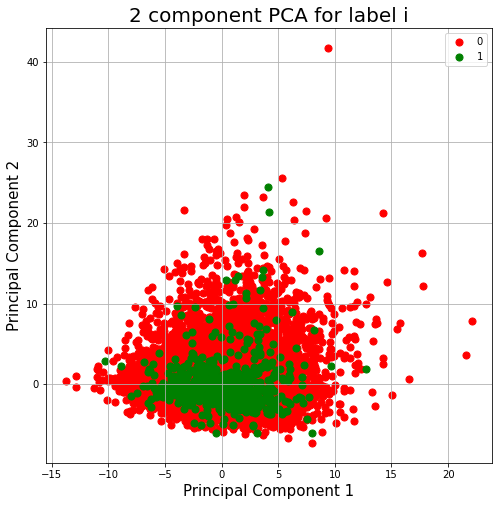

In [40]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[[df_train_labels.columns[9]]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for label i', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[df_train_labels.columns[9]] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_test_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_test_features.isnull().sum(axis=0))

In [29]:
# # aggregate data for each pid
# df_test_aggregate_features = df_test_features.groupby('pid').agg('median')

#print(df_test_aggregate_features)

# # collect all test pids
test_pids = list(set(df_test_features.pid))
df_test_agg_features = df_test_features.groupby('pid').agg([np.min, np.max, np.mean])

df_test_agg_features = df_test_agg_features.iloc[:,5:]
# Removing ETCo2
df_test_agg_features = df_test_agg_features.drop(df_test_agg_features.columns[[1,2,3]],  axis = 1)

In [30]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?

imputer = KNNImputer(n_neighbors= 10)
#imputer = IterativeImputer(random_state=0, verbose = 1)
df_test_agg_imputed_features = imputer.fit_transform(df_test_agg_features)

In [31]:
# scale test data
min_max_scaler = preprocessing.StandardScaler()
data_test_scaled = min_max_scaler.fit_transform(df_test_agg_imputed_features)

In [19]:
# pd.DataFrame(data_train_scaled).to_csv("./Results/4stats_iterarive_dat_train_scaled.csv")
# pd.DataFrame(data_test_scaled).to_csv("./Results/4stats_iterative_dat_test_scaled.csv")

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [36]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1, 12):
   
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = transformer.transform(data_test_scaled)

    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf = SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10)
    
    #parameters = {'C':np.linspace(0.1,10,20)}
#     clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 4,
#                                        refit = True, scoring = 'roc_auc', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    #print(clf.best_params_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

(18995, 20)
[False False False False False  True False False False False False False
 False  True  True False False False  True False  True False False False
  True False  True False False False False False False False False  True
 False False False False  True False False  True False False False False
 False  True False False False  True  True False  True False False False
  True  True False False False False False False False False False False
 False False False False False False False False False  True False False
 False False  True False False False False False False False  True False
 False  True False False False False False False False False False False]
(12664, 20)
[False False False False False  True False False False False False False
 False  True  True False False False  True False  True False False False
  True False  True False False False False False False False False  True
 False False False False  True False False  True False False False False
 False  True False False F

[LibSVM]ROC AUC for feature LABEL_Lactate  :  0.8989060284299264
(18995, 20)
[False False False False False False False  True False False False False
 False False False  True False False  True False  True  True False False
 False False False False  True False False  True False False False False
  True False  True False False  True False False False False  True False
 False False False  True False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False  True False False False False  True False False  True False
 False False False False  True False  True False  True False False False]
(12664, 20)
[False False False False False False False  True False False False False
 False False False  True False False  True False  True  True False False
 False False False False  True False False  True False False False False
  True False  True False False  Tr

In [ ]:
# labels that have a real value
columns_2 = []
from sklearn.kernel_ridge import KernelRidge

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 30)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = transformer.transform(data_test_scaled)
    
#     clf_w = SVR(kernel = 'poly', degree = 5, cache_size=7000)
# #     clf_w = NuSVR(nu=0.5, kernel = 'linear')
#     parameters = {'C':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 2,
#                                        refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf = KernelRidge(kernel = 'poly', degree = 5)
    clf.fit(train_features, df_train_labels.iloc[:,i])
#     print(clf.cv_results_)


    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    

R2 for feature LABEL_RRate  :  0.4549121830930438
R2 for feature LABEL_ABPm  :  0.4381890830585493
R2 for feature LABEL_SpO2  :  0.41006856722355167


In [44]:
columns_final = columns_1 + columns_2

### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

# columns_1 = [test_pids]

# for i in range(1,12):
    
#     clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
#     clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
#     pred = clf.predict(data_test_scaled)
#     prob = np.empty(len(pred))
#     for j in range(0, len(pred)):
#         prob[j] = 1 / (1 + math.exp(-pred[j]))
#     columns_1.append(prob)
    
#     pred_train = clf.predict(data_train_scaled)
#     prob_train = np.empty(len(pred_train))
#     for j in range(0, len(pred_train)):
#         prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
#     tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
#     print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [48]:
#labels that have a real value

columns_2 = []

for i in range(12, 16):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = transformer.transform(data_test_scaled)
    
    clf_w = LinearSVR()
    parameters = {'C':(0.1,1,10,30,60,100)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 2,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_)
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:    3.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'mean_fit_time': array([0.15803492, 0.72020221, 1.31950998, 1.50902951, 1.41405416,
       1.15272558]), 'std_fit_time': array([0.01236498, 0.10293007, 0.05689812, 0.00814259, 0.03442216,
       0.04160535]), 'mean_score_time': array([0.00132513, 0.00139034, 0.00163651, 0.00091887, 0.00078583,
       0.00069392]), 'std_score_time': array([1.90973282e-04, 2.23517418e-04, 4.86373901e-05, 3.81469727e-05,
       4.79221344e-05, 4.88758087e-06]), 'param_C': masked_array(data=[0.1, 1, 10, 30, 60, 100],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 30}, {'C': 60}, {'C': 100}], 'split0_test_score': array([-0.01048037, -0.0078689 , -0.00893145, -0.01131498, -0.03368533,
       -0.13924681]), 'split1_test_score': array([-0.02066229, -0.01702624, -0.02204602, -0.0470449 , -0.04619484,
       -0.14142441]), 'mean_test_score': array([-0.01557133, -0.01244757, -0.01548874, -0.02917994

KeyboardInterrupt: 

In [45]:
transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=20)
train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,11])
test_features = transformer.transform(data_test_scaled)

In [46]:
df_train_agg_features.columns[transformer.get_support(indices = True)]

MultiIndex([(        'Lactate', 'amax'),
            (        'Lactate', 'mean'),
            (           'Temp', 'amin'),
            (            'Hgb', 'amin'),
            (           'HCO3', 'mean'),
            (      'Phosphate', 'amin'),
            (      'Phosphate', 'amax'),
            (          'PaCO2', 'amax'),
            (          'PaCO2', 'mean'),
            (      'Platelets', 'amax'),
            (           'SaO2', 'mean'),
            (        'Glucose', 'amax'),
            (      'Magnesium', 'mean'),
            (           'ABPd', 'amin'),
            (        'Calcium', 'amin'),
            (           'SpO2', 'mean'),
            (       'Chloride', 'amin'),
            (      'Heartrate', 'mean'),
            ('Bilirubin_total', 'amax'),
            (             'pH', 'amin')],
           )

In [ ]:
columns_final = columns_1 + columns_2

### Random forest

In [ ]:
# Random forest Classifier
columns_1 = [test_pids]
for i in range(1, 12):
    clf = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', oob_score=False, bootstrap=False)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.oob_score)
    # compute probabilites as opposed to predictions
    probability = clf.apply(data_test_scaled)
    probs = [i[1] for i in probability] 
    columns_1.append(probs)
    
    
    probability = clf.predict_proba(data_train_scaled)

    probs = [i[1] for i in probability]            
    tmp = roc_auc_score(y_score= probs, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

## Save predictions

In [45]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)


In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')